# Surfs Up!

![title](Images/surfs-up.jpeg)

# Climate analysis and data exploration of the Hawaii climate database. 
All of the following analysis was completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

Connect to the Hawaii sqllite DB using SQLAlchemy and reflect Tables into the ORM 

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Or we can use the inspector to get the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Design a query to retrieve the last 12 months of precipitation data and plot the results

In [15]:
def get_date_prev_yr(last_date):
    yr = int(last_date.split("-")[0])
    mn = int(last_date.split("-")[1])
    dy = int(last_date.split("-")[2])
    return dt.date(yr, mn, dy) - dt.timedelta(days=365)
 
def get_last_date():
    return session.query(Measurement.date)\
        .order_by(Measurement.date.desc()).first()[0]

def get_query_date():
    return get_date_prev_yr(get_last_date()[0])


In [16]:
# Calculate the date 1 year ago from the last data point in the database using SqlAlchemy
last_date = get_last_date()
last_date

'2017-08-23'

In [17]:
query_date = get_date_prev_yr(last_date)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [18]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date)

In [19]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.read_sql(query.statement, engine).sort_values('date',ascending=False)
df.head()

,date,prcp
2229,2017-08-23,0.45
1528,2017-08-23,0.08
1008,2017-08-23,0.00
360,2017-08-23,0.00
1527,2017-08-22,0.00


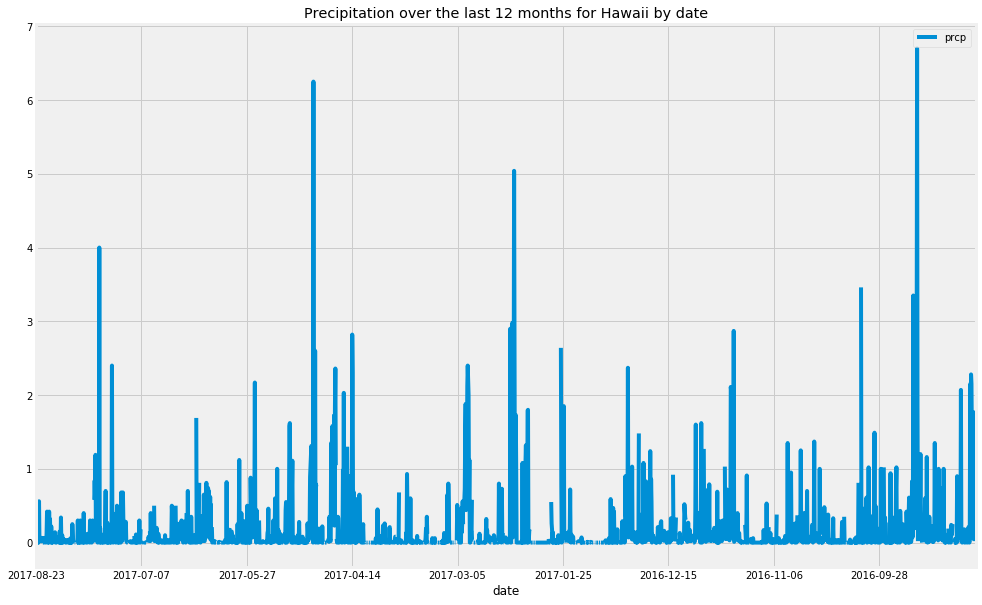

In [20]:
plt.rcParams['figure.figsize']=[15,10]
hawaii_df = df.set_index('date')
ax=hawaii_df.plot(title='Precipitation over the last 12 months for Hawaii by date');

In [21]:
# Create a Month column in order to be able to plot by month
df['Month'] = [d.split('-')[1] for d in df['date']]
df["Month"] = pd.to_numeric(df["Month"])

In [22]:
groupedByMonth_df = df.groupby('Month')
avg_prcp_by_month = groupedByMonth_df['prcp'].mean()
max_prcp_by_month = groupedByMonth_df['prcp'].max()

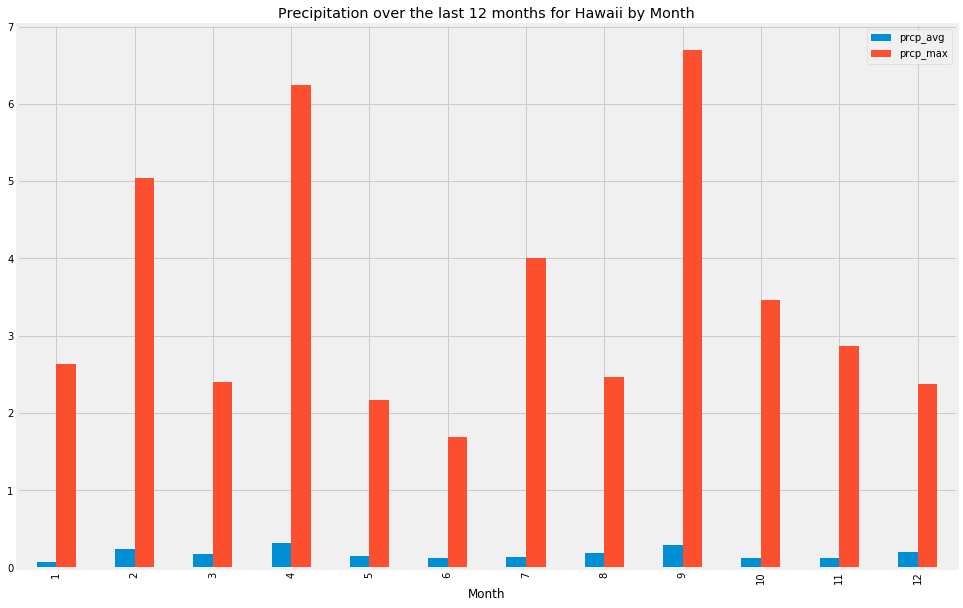

In [23]:
prcp_df = pd.merge(avg_prcp_by_month, max_prcp_by_month, on='Month', how='outer')
prcp_df.rename(columns={'prcp_x':'prcp_avg','prcp_y':'prcp_max'},inplace=True)
prcp_df.plot.bar(title='Precipitation over the last 12 months for Hawaii by Month');

In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp,Month
count,2021.000000,2230.000000
mean,0.177279,6.539013
std,0.461190,3.487857
min,0.000000,1.000000
25%,0.000000,4.000000
50%,0.020000,7.000000
75%,0.130000,10.000000
max,6.700000,12.000000


In [25]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()                         

9

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(func.count(Measurement.station),Measurement.station).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).\
                all()

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
query = session.query(Measurement.date,Measurement.tobs).filter(Measurement.station=='USC00519281')
active_df = pd.read_sql(query.statement, engine).sort_values('tobs',ascending=False)
active_df.describe()

,tobs
count,2772.000000
mean,71.663781
std,4.357642
min,54.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,85.000000


In [28]:
active_df.tail()

,date,tobs
2223,2016-02-08,56.0
1825,2015-01-05,56.0
1866,2015-02-15,56.0
1892,2015-03-13,56.0
1106,2013-01-16,54.0


In [29]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= query_date).\
                filter(Measurement.station=='USC00519281')
yr_active_df = pd.read_sql(query.statement, engine).sort_values('date',ascending=True)
yr_active_df['Month'] = [d.split('-')[1] for d in yr_active_df['date']]
yr_active_df["Month"] = pd.to_numeric(yr_active_df["Month"])
yr_active_df = yr_active_df.set_index('Month')
yr_active_df.head()

,date,tobs
Month,,
8,2016-08-23,77.0
8,2016-08-24,77.0
8,2016-08-25,80.0
8,2016-08-26,80.0
8,2016-08-27,75.0


In [30]:
active_df.describe()

,tobs
count,2772.000000
mean,71.663781
std,4.357642
min,54.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,85.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1151b0208>]],
      dtype=object)

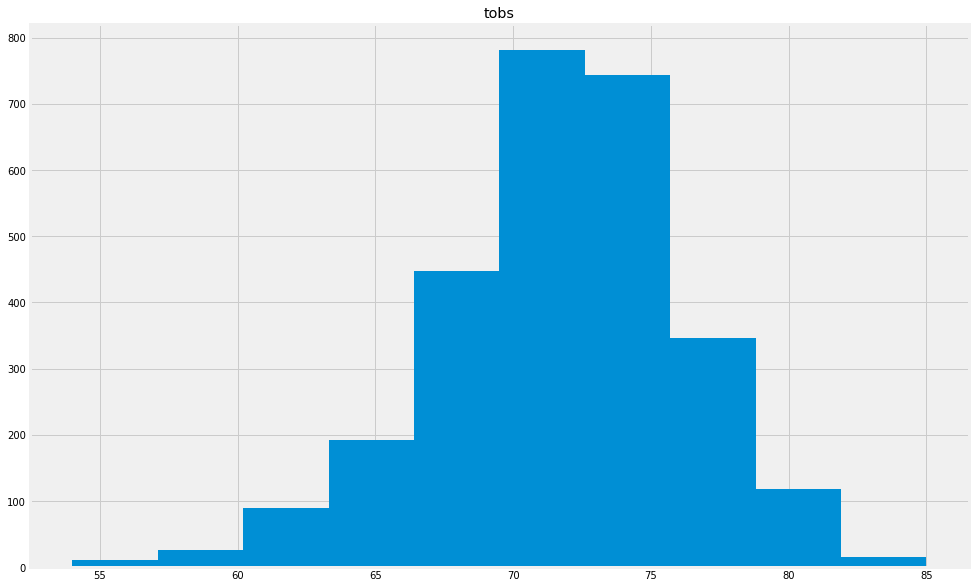

In [31]:
active_df.hist(column='tobs')

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [33]:
 def calc_temps_y(y):
        args = calc_temps(str(y)+'-02-28',str(y)+'-03-05')
        return (*args[0]), y

In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_years_temp = [calc_temps_y(y) for y in range(2012,2018)]

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_avg_temp_df = pd.DataFrame(prev_years_temp,columns=['TMIN','TAVG','TMAX','YEAR'])

In [36]:
trip_avg_temp_df.set_index('YEAR')

,TMIN,TAVG,TMAX
YEAR,,,
2012,62.0,69.571429,74.0
2013,60.0,70.159091,75.0
2014,57.0,67.644444,76.0
2015,65.0,71.590909,78.0
2016,62.0,69.886364,80.0
2017,64.0,72.027778,78.0


(50, 80)

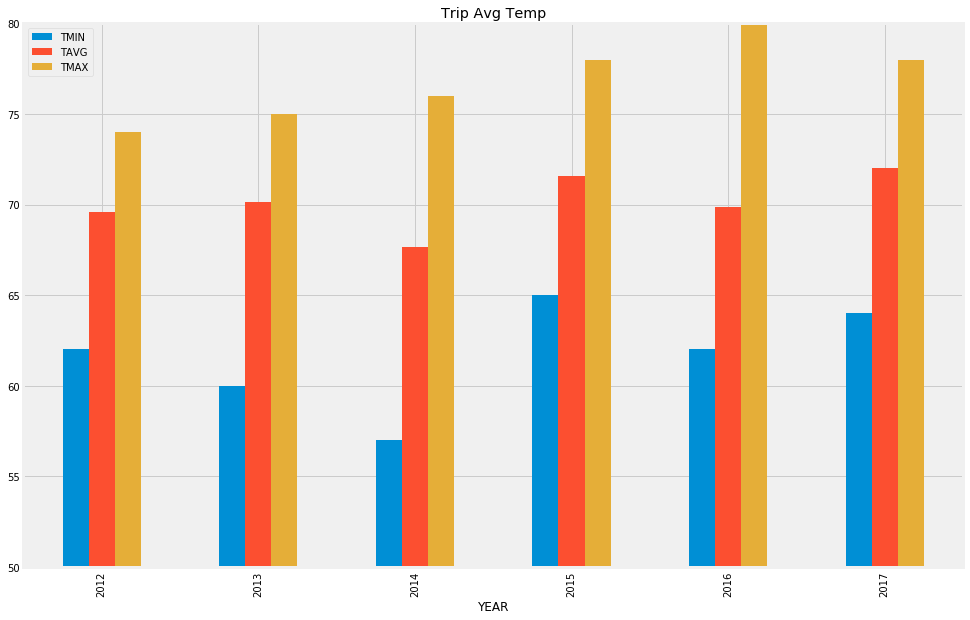

In [37]:
ax = trip_avg_temp_df.plot.bar(x='YEAR', title='Trip Avg Temp')
ax.set_ylim(50,80)

In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def total_rain(station, start_date, end_date):
    """Total rainfall for the weather station for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        station (string): station id
    Returns:
        TotalRainfall
    """
    
    return session.query(func.sum(Measurement.prcp)).\
        filter(Measurement.station==station).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).first()

# function usage example
print(total_rain('USC00519281','2012-02-28', '2012-03-05'))

(11.08,)


In [39]:
def total_rain_y(s,y):
        r = total_rain(s,str(y)+'-02-28',str(y)+'-03-05')
        return r[0]
    
print(total_rain_y('USC00519281','2012'))

11.08


In [40]:
stations = session.query(Measurement.station).distinct().all()
station_id = []
for s in stations:
    station_id.append(s[0])
station_id

['USC00519397',
 'USC00513117',
 'USC00514830',
 'USC00517948',
 'USC00518838',
 'USC00519523',
 'USC00519281',
 'USC00511918',
 'USC00516128']

In [41]:
[total_rain_y('USC00519397',y) for y in range(2012,2018)]

[1.1800000000000002, 0.0, 0.89, 0.65, 0.0, 2.7399999999999998]

In [42]:
prev_years_rain = []
for s in station_id:
    rain = [total_rain_y(s,y) for y in range(2012,2018)]
    row = [s, *rain]
    prev_years_rain.append(row)

In [43]:
total_rain_df = pd.DataFrame(prev_years_rain, columns=['station','2012','2013','2014','2015','2016','2017'])
total_rain_df = total_rain_df.\
                sort_values(by=['2017','2016','2015','2014','2013','2012'],ascending=False)
total_rain_df

,station,2012,2013,2014,2015,2016,2017
6,USC00519281,11.08,0.03,0.93,2.02,0.01,4.72
1,USC00513117,5.79,0.00,0.80,1.16,0.00,4.45
8,USC00516128,10.32,0.17,1.50,2.65,0.02,4.07
3,USC00517948,0.00,0.00,0.03,0.00,NaN,2.98
0,USC00519397,1.18,0.00,0.89,0.65,0.00,2.74
5,USC00519523,2.92,0.03,0.48,1.39,0.33,2.32
2,USC00514830,0.03,0.00,0.64,0.48,0.12,1.16
7,USC00511918,0.76,0.00,1.02,0.17,NaN,NaN
4,USC00518838,3.84,NaN,NaN,NaN,NaN,NaN


In [44]:
# Convert Station table to DataFrame
query = session.query(Station)
Station_df = pd.read_sql(query.statement, engine)
del(Station_df['id'])
Station_df.head()

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [45]:
# Merge the two tables
hawaii_df = pd.merge(total_rain_df, Station_df, on='station', how='left')
hawaii_df.head()

,station,2012,2013,2014,2015,2016,2017,name,latitude,longitude,elevation
0,USC00519281,11.08,0.03,0.93,2.02,0.01,4.72,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,USC00513117,5.79,0.00,0.80,1.16,0.00,4.45,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00516128,10.32,0.17,1.50,2.65,0.02,4.07,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,USC00517948,0.00,0.00,0.03,0.00,NaN,2.98,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00519397,1.18,0.00,0.89,0.65,0.00,2.74,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


## Optional Challenge Assignment

In [46]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [47]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
date_range = ['02-28','03-01','03-02','03-03','03-04','03-05']
normals = [(d,*daily_normals(d)[0]) for d in date_range]
normals

[('02-28', 65.0, 70.65517241379311, 80.0),
 ('03-01', 64.0, 70.0327868852459, 76.0),
 ('03-02', 61.0, 70.36666666666666, 78.0),
 ('03-03', 60.0, 70.06896551724138, 78.0),
 ('03-04', 57.0, 69.27272727272727, 77.0),
 ('03-05', 60.0, 67.89090909090909, 76.0)]

In [48]:
def getDTObj(s):
    m = pd.to_numeric(s.split('-')[0])
    d = pd.to_numeric(s.split('-')[1])
    return dt.date(2017, m, d)

In [49]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['trip_dates','TMIN','TAVG','TMAX'])
normals_df['trip_dates'] = normals_df['trip_dates'].apply(getDTObj)
normals_df.set_index('trip_dates')

,TMIN,TAVG,TMAX
trip_dates,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0


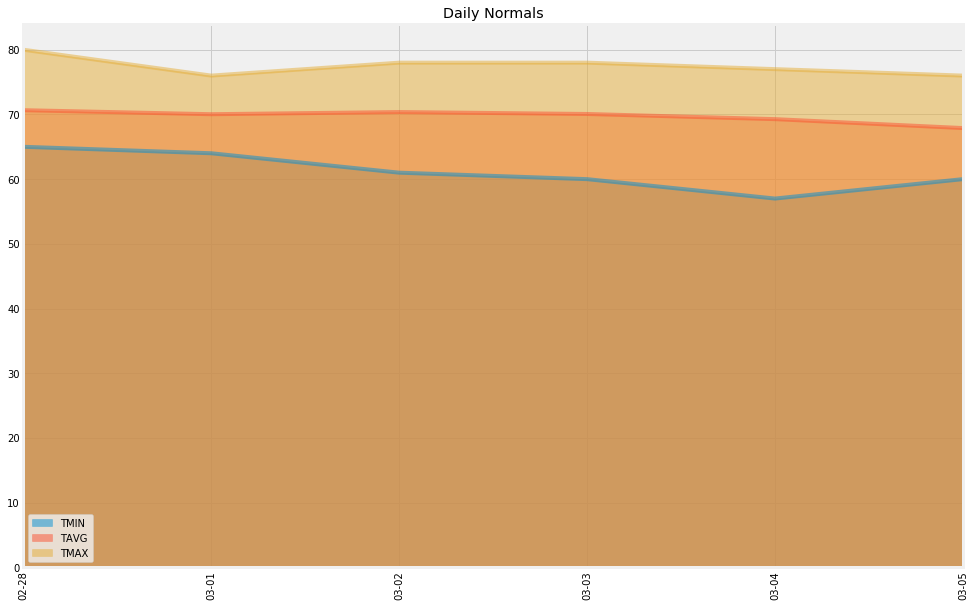

In [50]:
# Plot the daily normals as an area plot with `stacked=False`
x_axis = np.arange(len(normals_df))
tick_locations = [value for value in x_axis]
ax = normals_df.plot.area(stacked=False, title='Daily Normals',use_index='trip_dates')
plt.xticks(tick_locations, date_range, rotation="vertical")
plt.show()